### Training and Testing of the Baseline and HNN Models on a Spring-Mass System

In [2]:
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg


In [3]:
import scipy.integrate 
solve_ivp = scipy.integrate.solve_ivp

In [4]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from baseline_models import BaselineMLP
from hnn import HNN 
from utils import L2Loss, rk4

In [5]:
import utils 
print(dir(utils))

['L2Loss', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'np', 'rk4', 'scipy', 'solve_ivp', 'torch']


In [6]:
from data import get_dataset, get_field, trajectory

### Which Loss Function to choose for this? 

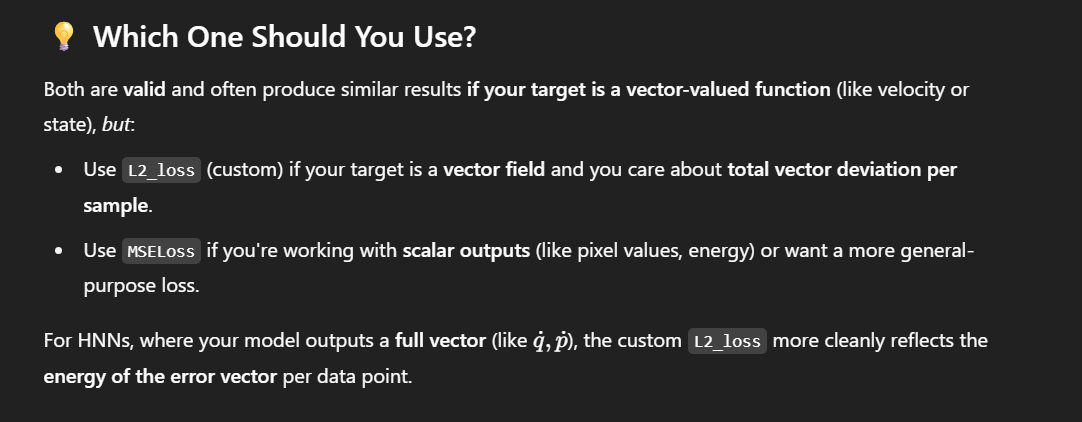

In [7]:


torch.manual_seed(0)
np.random.seed(0)

#according to the paper and my intuition, initializing the model and optimizer
input_dim = 2
hidden_dim = 200 
output_dim = 2 

nn_model = BaselineMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim)
baseline_model = HNN(input_dim=input_dim, differentiable_model=nn_model, baseline=True)
model = HNN(input_dim=input_dim, differentiable_model=nn_model)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)



In [8]:
#arranging the data and turning them to tensors 
data = get_dataset(seed=0)
x_train = torch.tensor(data['train_x'], requires_grad=True, dtype=torch.float32) #z = [q p]
x_test = torch.tensor(data['test_x'], requires_grad=True, dtype=torch.float32)
dxdt_train = torch.tensor(data['train_dx']) #z' = [q' p'], these are the targets
dxdt_test= torch.tensor(data['test_dx']) 

### Inspecting the Dataset 

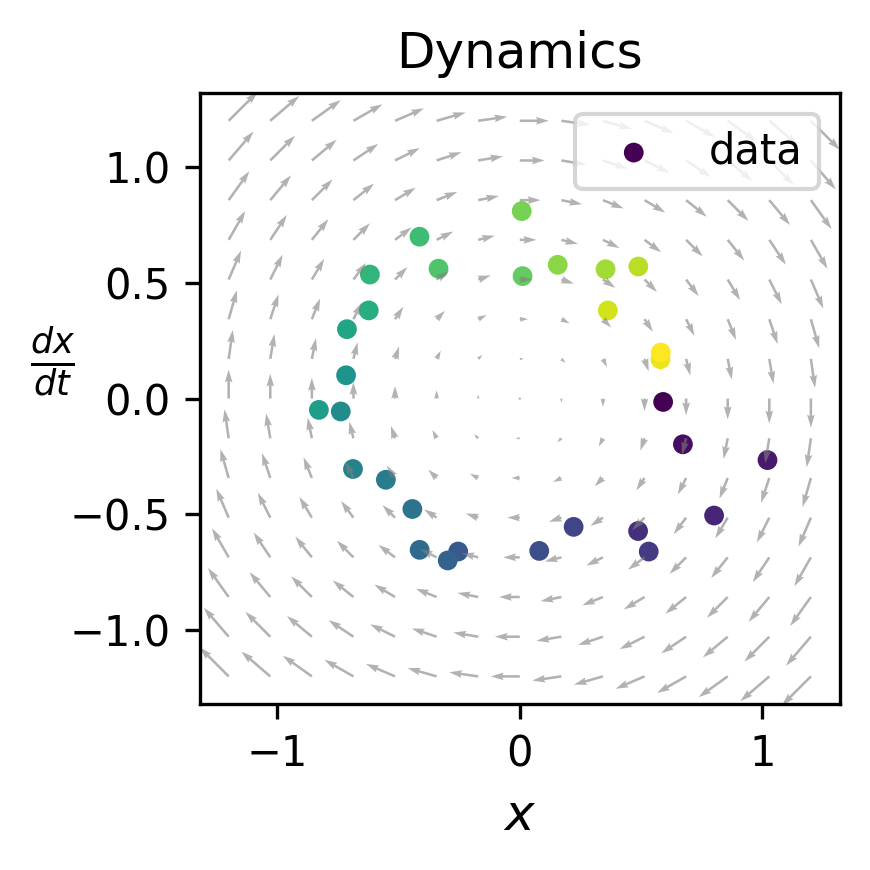

In [9]:
field = get_field(gridsize=15)
data = get_dataset(seed=0)

fig = plt.figure(figsize=(3,3), facecolor='white', dpi=300)

# Get trajectory data
q, p, dqdt, dpdt, t_eval = trajectory(radius=0.7, y0=np.array([1,0]), noise_std=0.1)
x, y, dx, dy, t = q.squeeze(), p.squeeze(), dqdt.squeeze(), dpdt.squeeze(), t_eval

# Plot trajectory
plt.scatter(x, y, c=t, s=14, label='data')

# Plot vector field
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1], 
           cmap='gray_r', color=(.5,.5,.5), alpha=0.6)

plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=12)
plt.title("Dynamics")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show() 

### Training and Testing

In [10]:
#normal training loop
epochs = 2000 
stats = {'training_loss':[], 'testing_loss':[] }
for epoch in range(epochs):

    baseline_model.train()

    dxdt_hat_train = baseline_model.time_derivative(x_train)

    train_loss = L2Loss(dxdt_train, dxdt_hat_train)
    stats['training_loss'].append(train_loss)

    optim.zero_grad()

    train_loss.backward()

    optim.step()

    #testing 
    baseline_model.eval()
    with torch.inference_mode():
        # print(x_test.shape)
        # print(dxdt_hat_train.shape)
        x_test.requires_grad_(True) #enable gradient tracking for the in graph gradient
        dxdt_hat_test = baseline_model.time_derivative(x_test) 
        test_loss = L2Loss(dxdt_hat_test, dxdt_test)
        stats['testing_loss'].append(test_loss)
    
    if epoch % 10 == 0 :
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}  | Test Loss: {test_loss:.5f} ")
    

Epoch: 0 | Train Loss: 0.84181  | Test Loss: 0.86311 
Epoch: 10 | Train Loss: 0.47223  | Test Loss: 0.41244 
Epoch: 20 | Train Loss: 0.18215  | Test Loss: 0.15282 
Epoch: 30 | Train Loss: 0.05253  | Test Loss: 0.04974 
Epoch: 40 | Train Loss: 0.04696  | Test Loss: 0.04678 
Epoch: 50 | Train Loss: 0.04317  | Test Loss: 0.04129 
Epoch: 60 | Train Loss: 0.03822  | Test Loss: 0.03693 
Epoch: 70 | Train Loss: 0.03827  | Test Loss: 0.03696 
Epoch: 80 | Train Loss: 0.03769  | Test Loss: 0.03669 
Epoch: 90 | Train Loss: 0.03759  | Test Loss: 0.03664 
Epoch: 100 | Train Loss: 0.03755  | Test Loss: 0.03654 
Epoch: 110 | Train Loss: 0.03753  | Test Loss: 0.03651 
Epoch: 120 | Train Loss: 0.03753  | Test Loss: 0.03653 
Epoch: 130 | Train Loss: 0.03752  | Test Loss: 0.03653 
Epoch: 140 | Train Loss: 0.03752  | Test Loss: 0.03652 
Epoch: 150 | Train Loss: 0.03752  | Test Loss: 0.03652 
Epoch: 160 | Train Loss: 0.03752  | Test Loss: 0.03653 
Epoch: 170 | Train Loss: 0.03751  | Test Loss: 0.03653 
Epo

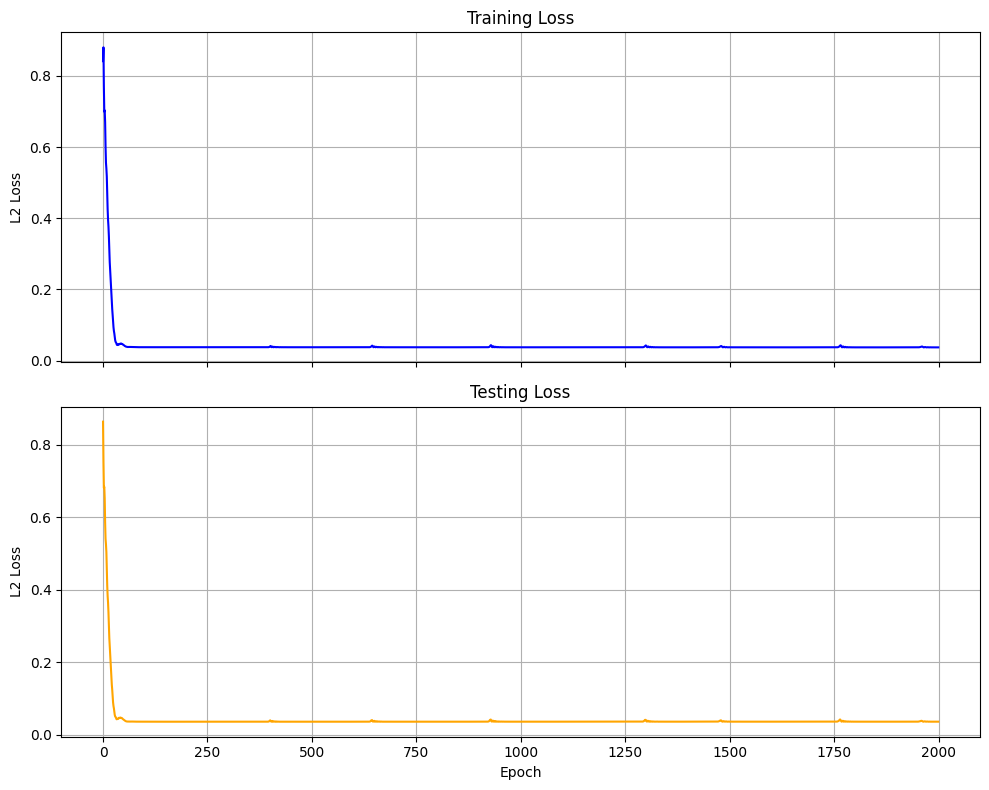

In [11]:
# Convert loss tensors to floats
train_losses = [loss.item() for loss in stats['training_loss']]
test_losses = [loss.item() for loss in stats['testing_loss']]

# Create two subplots: one for training loss, one for testing loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
axs[0].plot(train_losses, color='blue')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('L2 Loss')
axs[0].grid(True)

# Plot testing loss
axs[1].plot(test_losses, color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [12]:
#normal training loop
epochs = 2000 
stats = {'training_loss':[], 'testing_loss':[] }
for epoch in range(epochs):

    model.train()

    dxdt_hat_train = model.time_derivative(x_train)

    train_loss = L2Loss(dxdt_train, dxdt_hat_train)
    stats['training_loss'].append(train_loss)

    optim.zero_grad()

    train_loss.backward()

    optim.step()

    #testing 
   
    x_test.requires_grad_(True) #enable gradient tracking for the in graph gradient
    dxdt_hat_test = model.time_derivative(x_test) 
    test_loss = L2Loss(dxdt_hat_test, dxdt_test)
    stats['testing_loss'].append(test_loss)
    
    if epoch % 10 == 0 :
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}  | Test Loss: {test_loss:.5f} ")
    

Epoch: 0 | Train Loss: 2.65380  | Test Loss: 1.92840 
Epoch: 10 | Train Loss: 0.84780  | Test Loss: 0.77085 
Epoch: 20 | Train Loss: 0.60269  | Test Loss: 0.55530 
Epoch: 30 | Train Loss: 0.43033  | Test Loss: 0.41583 
Epoch: 40 | Train Loss: 0.38291  | Test Loss: 0.36319 
Epoch: 50 | Train Loss: 0.28277  | Test Loss: 0.26012 
Epoch: 60 | Train Loss: 0.08141  | Test Loss: 0.06391 
Epoch: 70 | Train Loss: 0.04544  | Test Loss: 0.04191 
Epoch: 80 | Train Loss: 0.04086  | Test Loss: 0.03950 
Epoch: 90 | Train Loss: 0.03891  | Test Loss: 0.03702 
Epoch: 100 | Train Loss: 0.03811  | Test Loss: 0.03690 
Epoch: 110 | Train Loss: 0.03766  | Test Loss: 0.03648 
Epoch: 120 | Train Loss: 0.03746  | Test Loss: 0.03627 
Epoch: 130 | Train Loss: 0.03730  | Test Loss: 0.03619 
Epoch: 140 | Train Loss: 0.03719  | Test Loss: 0.03601 
Epoch: 150 | Train Loss: 0.03711  | Test Loss: 0.03598 
Epoch: 160 | Train Loss: 0.03705  | Test Loss: 0.03591 
Epoch: 170 | Train Loss: 0.03701  | Test Loss: 0.03585 
Epo

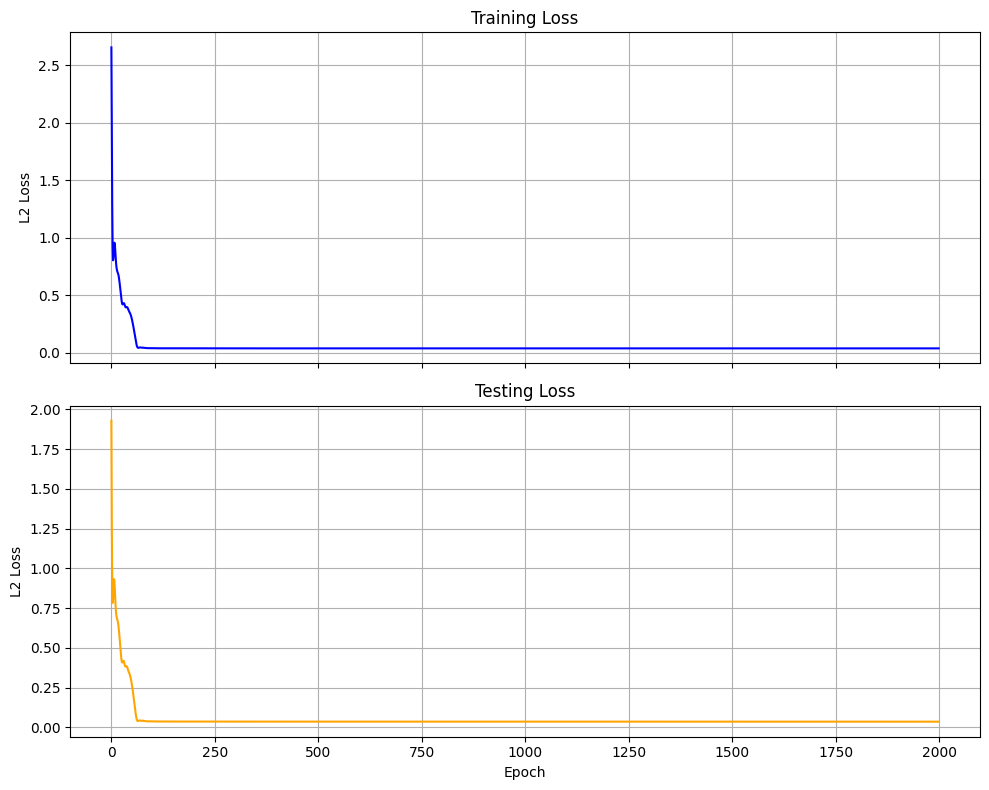

In [13]:
# Convert loss tensors to floats
train_losses = [loss.item() for loss in stats['training_loss']]
test_losses = [loss.item() for loss in stats['testing_loss']]

# Create two subplots: one for training loss, one for testing loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
axs[0].plot(train_losses, color='blue')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('L2 Loss')
axs[0].grid(True)

# Plot testing loss
axs[1].plot(test_losses, color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Run Analysis

In [14]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']

    #running the model 
    mesh_x = torch.tensor(np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

In [15]:
def integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx 
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [26]:
field = get_field(gridsize=10)
data = get_dataset(seed=0)

#getting the vector fields
baseline_field = get_vector_field(baseline_model, gridsize=10)
hnn_field = get_vector_field(model, gridsize=10)

#integrating along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1.,0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
base_ivp = integrate_model(baseline_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(model, t_span, y0, **kwargs)

In [17]:
base_ivp, hnn_ivp 

(  message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  1.501e-02 ...  2.998e+01  3.000e+01]
         y: [[ 1.000e+00  9.893e-01 ... -3.825e+01 -3.827e+01]
             [ 0.000e+00 -8.488e-02 ... -1.745e+01 -1.746e+01]]
       sol: None
  t_events: None
  y_events: None
      nfev: 218
      njev: 0
       nlu: 0,
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  1.501e-02 ...  2.998e+01  3.000e+01]
         y: [[ 1.000e+00  9.997e-01 ...  6.155e-01  6.369e-01]
             [ 0.000e+00 -2.753e-02 ...  7.707e-01  7.529e-01]]
       sol: None
  t_events: None
  y_events: None
      nfev: 1298
      njev: 0
       nlu: 0)

Text(0.5, 1.0, 'Hamiltonian NN')

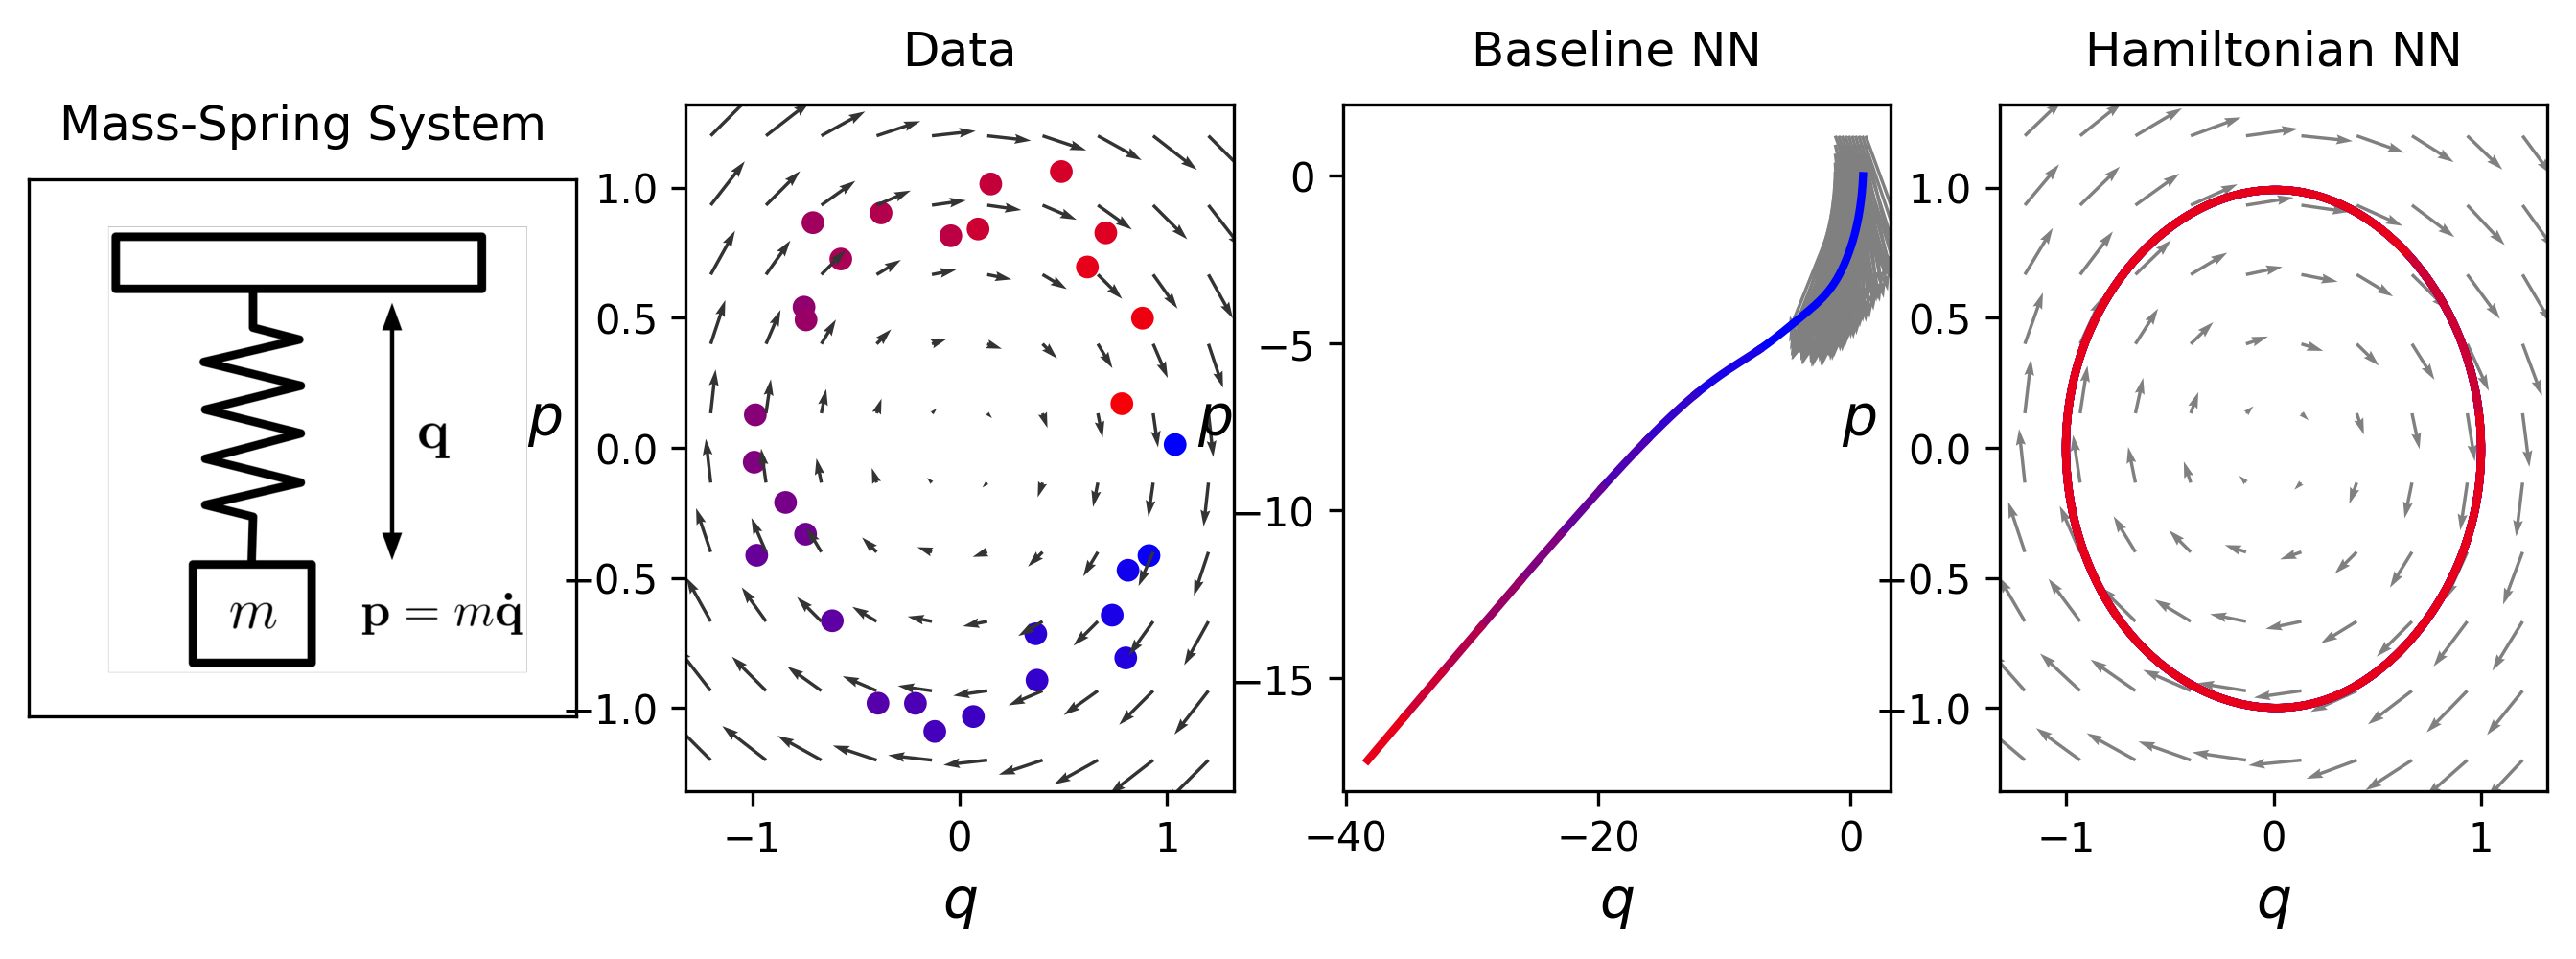

In [29]:
#Plotting the results 
fig = plt.figure(figsize=(11.3,3.1), facecolor='white', dpi=300)

#plot physical system 
fig.add_subplot(1,4,1, frameon=True)
plt.xticks([]) ; plt.yticks([])
schema = mpimg.imread(r'C:\Users\Neel\ResearchProjects\Hamiltonian_Neural_Networks\experiment_spring\mass-spring.png')
plt.imshow(schema, cmap='gray')
plt.title("Mass-Spring System", pad=10)

#plot dynamics 
fig.add_subplot(1,4,2,frameon=True)
x,y, dx, dy, t = trajectory(radius=1, y0=np.array([1,0]))
N = len(x)
point_colours = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colours)
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1], cmap='gray_r', scale=30, width=6e-3, color=(.2,.2,.2))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

#plot baseline 
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], baseline_field[:,0], baseline_field[:,1],
        cmap='gray_r', scale=20, width=6e-3, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, 10)):
    color = (float(i)/10, 0, 1-float(i)/10)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=2)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

#plot HNN
fig.add_subplot(1,4,4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1], cmap='gray_r', scale=20, width=6e-3, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, 10)):
    colour = (float(i)/10,0, 1-float(i)/10)
    plt.plot(l[:,0], l[:,1], color=colour, linewidth=2)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)



In [19]:
baseline_field.shape, hnn_field.shape

((225, 2), (225, 2))

In [21]:
print("baseline_field shape:", baseline_field.shape)
print("hnn_field shape:", hnn_field.shape) 
print("base_ivp keys:", base_ivp.keys())
print("Sample baseline_field values:", baseline_field[:5])

baseline_field shape: (225, 2)
hnn_field shape: (225, 2)
base_ivp keys: dict_keys(['t', 'y', 'sol', 't_events', 'y_events', 'nfev', 'njev', 'nlu', 'status', 'message', 'success'])
Sample baseline_field values: [[-1.7166395 -4.2760816]
 [-1.7767467 -4.4838586]
 [-1.8365502 -4.6846333]
 [-1.8963487 -4.8682313]
 [-1.9563434 -5.025366 ]]


In [20]:
base_ivp['y'].shape, hnn_ivp['y'].shape

((2, 2000), (2, 2000))